In [1]:
! pip install transformers
! pip install datasets

You should consider upgrading via the 'd:\programas\python37\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'd:\programas\python37\python.exe -m pip install --upgrade pip' command.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding
import tensorflow as tf
from sklearn.utils import class_weight 
import keras

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
import seaborn as sns

import yaml

In [2]:
with open("../../config.yaml", "r") as stream:
    try:
        configs = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
SEED  = configs['SEED']
PATH_TO_TRAIN_DS_PROCESSED = str(configs['ROOT_DIR'] + configs['PATH_TO_TRAIN_DS_PROCESSED'])
PATH_TO_MODELS  = str(configs['ROOT_DIR'] + configs['PATH_TO_MODELS'])
PATH_TO_WEIGHTS = str(configs['ROOT_DIR'] + configs['PATH_TO_WEIGHTS'])

In [4]:
base = pd.read_csv(PATH_TO_TRAIN_DS_PROCESSED)
base.head()

,image_name,text,humour,sarcasm,offensive,motivational,target
0,image_1415.jpeg,if you want to view paradis simpli look around...,not_funny,not_sarcastic,not_offensive,motivational,positive
1,image_6460.png,if i had a brick for everi lie hillari told i ...,hilarious,general,very_offensive,motivational,positive
2,image_2303.png,that thing over there can i eat that,very_funny,general,not_offensive,motivational,very_positive
3,image_2417.png,my dad point to liam and said when did david b...,not_funny,general,very_offensive,motivational,neutral
4,image_11.jpg,probabl the first man to do year challeng chen...,funny,general,very_offensive,motivational,negative


In [5]:
base.drop(columns=['image_name', 'humour', 'sarcasm','offensive','motivational'], inplace=True)
base.head()

,text,target
0,if you want to view paradis simpli look around...,positive
1,if i had a brick for everi lie hillari told i ...,positive
2,that thing over there can i eat that,very_positive
3,my dad point to liam and said when did david b...,neutral
4,probabl the first man to do year challeng chen...,negative


#### Considerando somente as labels 'negative', 'neutral' e 'positive'.

In [6]:
base.target.replace("very_positive", 
           "positive", 
           inplace=True)
base.target.replace("very_negative", 
           "negative", 
           inplace=True)    
NUM_LABELS = len(base.target.unique())
base.target = base.target.astype('category').cat.codes

base.head()

,text,target
0,if you want to view paradis simpli look around...,2
1,if i had a brick for everi lie hillari told i ...,2
2,that thing over there can i eat that,2
3,my dad point to liam and said when did david b...,1
4,probabl the first man to do year challeng chen...,0


In [7]:
train, val = train_test_split(base, test_size=0.2, random_state=SEED)
print(train.shape, val.shape)

(4362, 2) (1091, 2)


In [8]:
dataset_train = Dataset.from_pandas(train, preserve_index=False)
dataset_val = Dataset.from_pandas(val, preserve_index=False)

In [9]:
dataset_train

Dataset({
    features: ['text', 'target'],
    num_rows: 4362
})

In [10]:
dataset_val

Dataset({
    features: ['text', 'target'],
    num_rows: 1091
})

# Utilização dos transformers

In [11]:
model_name = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

In [12]:
def tokenize_function(sample):
  return tokenizer(sample["text"])

tokenized_dataset_train = dataset_train.map(tokenize_function)
tokenized_dataset_val = dataset_val.map(tokenize_function)

Parameter 'function'=<function tokenize_function at 0x00000276F1DF4D90> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4362 [00:00<?, ?ex/s]

  0%|          | 0/1091 [00:00<?, ?ex/s]

In [13]:
tokenized_dataset_train

Dataset({
    features: ['text', 'target', 'input_ids', 'attention_mask'],
    num_rows: 4362
})

In [14]:
tokenized_dataset_val

Dataset({
    features: ['text', 'target', 'input_ids', 'attention_mask'],
    num_rows: 1091
})

In [15]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

In [16]:
tf_train_dataset = tokenized_dataset_train.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

In [17]:
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [18]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=NUM_LABELS)

Downloading:   0%|          | 0.00/627M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
class BalancedSparseCategoricalAccuracy(keras.metrics.SparseCategoricalAccuracy):
    def __init__(self, name='balanced_sparse_categorical_accuracy', dtype=None):
        super().__init__(name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_flat = y_true
        if y_true.shape.ndims == y_pred.shape.ndims:
            y_flat = tf.squeeze(y_flat, axis=[-1])
        y_true_int = tf.cast(y_flat, tf.int32)

        cls_counts = tf.math.bincount(y_true_int)
        cls_counts = tf.math.reciprocal_no_nan(tf.cast(cls_counts, self.dtype))
        weight = tf.gather(cls_counts, y_true_int)
        return super().update_state(y_true, y_pred, sample_weight=weight)

In [20]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

model.compile(
    optimizer=opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[BalancedSparseCategoricalAccuracy()]
)
model.summary()

Model: "tf_roberta_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592899    
 ficationHead)                                                   
                                                                 
Total params: 124,647,939
Trainable params: 124,647,939
Non-trainable params: 0
_________________________________________________________________


In [21]:
weights = class_weight.compute_class_weight(class_weight='balanced', classes = np.unique(train.target) ,y = train.target).ravel()
class_weights = dict((i,v) for i, v in enumerate(weights))
class_weights

{0: 3.5901234567901232, 1: 1.0699043414275202, 2: 0.5596612779060816}

In [22]:
model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=10, class_weight = class_weights)

Epoch 1/10
546/546 [==============================] - 969s 2s/step - loss: 1.1020 - balanced_sparse_categorical_accuracy: 0.3134 - val_loss: 1.0808 - val_balanced_sparse_categorical_accuracy: 0.3800
Epoch 2/10
546/546 [==============================] - 942s 2s/step - loss: 1.0994 - balanced_sparse_categorical_accuracy: 0.3388 - val_loss: 1.0628 - val_balanced_sparse_categorical_accuracy: 0.3710
Epoch 3/10
546/546 [==============================] - 908s 2s/step - loss: 1.0897 - balanced_sparse_categorical_accuracy: 0.3697 - val_loss: 1.1408 - val_balanced_sparse_categorical_accuracy: 0.2556
Epoch 4/10
546/546 [==============================] - 900s 2s/step - loss: 1.0290 - balanced_sparse_categorical_accuracy: 0.4414 - val_loss: 1.1463 - val_balanced_sparse_categorical_accuracy: 0.3233
Epoch 5/10
546/546 [==============================] - 900s 2s/step - loss: 0.8414 - balanced_sparse_categorical_accuracy: 0.5741 - val_loss: 1.1157 - val_balanced_sparse_categorical_accuracy: 0.3777
Epoch

In [23]:
preds = model.predict(tf_val_dataset, verbose=1)
preds

137/137 [==============================] - 52s 356ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[-0.19087979, -1.2020035 ,  1.5307783 ],
       [-2.2945757 , -1.2491194 ,  3.8349245 ],
       [-4.401391  ,  3.4730864 ,  0.7364215 ],
       ...,
       [-3.907759  ,  3.1372478 ,  0.70754105],
       [-1.1489426 , -0.28807667,  1.4305646 ],
       [-2.948936  ,  0.23917764,  2.6663866 ]], dtype=float32), hidden_states=None, attentions=None)

In [24]:
loss, accuracy = model.evaluate(tf_val_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

137/137 [==============================] - 48s 352ms/step - loss: 1.8998 - balanced_sparse_categorical_accuracy: 0.3619
Loss: 1.8997732400894165
Accuracy: 0.3619326651096344


In [25]:
loss, accuracy = model.evaluate(tf_train_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

546/546 [==============================] - 191s 351ms/step - loss: 0.4458 - balanced_sparse_categorical_accuracy: 0.8558
Loss: 0.4457909166812897
Accuracy: 0.8557717800140381


In [26]:
preds['logits']

array([[-0.19087979, -1.2020035 ,  1.5307783 ],
       [-2.2945757 , -1.2491194 ,  3.8349245 ],
       [-4.401391  ,  3.4730864 ,  0.7364215 ],
       ...,
       [-3.907759  ,  3.1372478 ,  0.70754105],
       [-1.1489426 , -0.28807667,  1.4305646 ],
       [-2.948936  ,  0.23917764,  2.6663866 ]], dtype=float32)

In [27]:
tf.nn.softmax(preds['logits']).numpy()

array([[1.4372762e-01, 5.2289527e-02, 8.0398291e-01],
       [2.1595878e-03, 6.1433716e-03, 9.9169707e-01],
       [3.5705941e-04, 9.3882048e-01, 6.0822483e-02],
       ...,
       [8.0055417e-04, 9.1832894e-01, 8.0870479e-02],
       [6.0401622e-02, 1.4286241e-01, 7.9673594e-01],
       [3.3350608e-03, 8.0850735e-02, 9.1581422e-01]], dtype=float32)

# Salvando o modelo

In [28]:
model.save_weights(PATH_TO_WEIGHTS + model_name + '.hdf5')
model.save_pretrained(PATH_TO_MODELS + model_name)

# VALIDAÇÃO COM ACURÁCIA BALANCEADA!

In [9]:
model_name = "roberta-base"

In [10]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)
model.load_weights(PATH_TO_WEIGHTS + model_name + '.hdf5')

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
def tokenize_function(sample):
  return tokenizer(sample["text"])

dataset_val = Dataset.from_pandas(val, preserve_index=False)
tokenized_dataset_val = dataset_val.map(tokenize_function)

Parameter 'function'=<function tokenize_function at 0x000001882400A840> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/1091 [00:00<?, ?ex/s]

In [12]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")
tf_val_dataset = tokenized_dataset_val.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["target"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [15]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[BalancedSparseCategoricalAccuracy()]
)

In [16]:
preds = model.predict(tf_val_dataset, verbose=3)
preds

TFSequenceClassifierOutput(loss=None, logits=array([[-0.19087979, -1.2020035 ,  1.5307783 ],
       [-2.2945757 , -1.2491194 ,  3.8349245 ],
       [-4.401391  ,  3.4730864 ,  0.7364215 ],
       ...,
       [-3.907759  ,  3.1372478 ,  0.70754105],
       [-1.1489426 , -0.28807667,  1.4305646 ],
       [-2.948936  ,  0.23917764,  2.6663866 ]], dtype=float32), hidden_states=None, attentions=None)

In [17]:
prob = tf.nn.softmax(preds['logits']).numpy()
y_pred = np.argmax(prob, axis=1)

In [25]:
print("Val - balanced_accuracy : ", balanced_accuracy_score(val.target,  y_pred))
print("Val - F1 : ", f1_score(val.target, y_pred, average='macro'))

Val - balanced_accuracy :  0.3196528625188959
Val - F1 :  0.29048413588261096


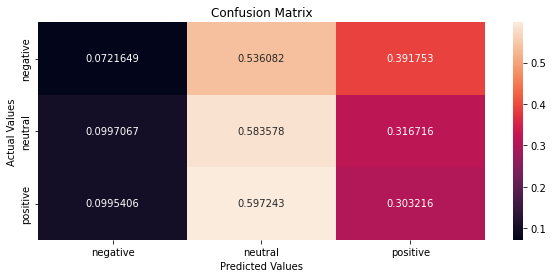

In [27]:
labels = ['negative', 'neutral', 'positive']
cm = confusion_matrix(val.target, y_pred)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_df = pd.DataFrame(cmn,
                     index = labels, 
                     columns = labels
                     )

plt.figure(figsize=(10,4))
sns.heatmap(cm_df, annot=True ,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()